In [53]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import sys, copy
import numpy as np
import pyccl as ccl
#sys.path.append('../modules/')
import ModelClusterObservables
sys.path.append('../modules/')
import halo._halo_abundance
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Count and lensing mass models

In [54]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_internal_validation.ini')
default_config_capish['summary_statistics']['richness_edges'] = '20, 25, 30, 35, 40, 50, 80, 100'
default_config_capish['summary_statistics']['redshift_edges'] = '0.2, 0.5'

In [55]:
ClusterAbundanceObject = ModelClusterObservables.UniversePrediction( default_config=default_config_capish )

In [56]:
params_default = ClusterAbundanceObject.params_default 
cosmo_fid = params_default['CCL_cosmology']
params_new = params_default
compute_new= {'compute_dNdzdlogMdOmega':False,'compute_richness_mass_relation':False, 
               'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':True,
             'compute_dNdzdlogMdOmega_log_slope': False}
adds_new={'add_purity':False, 'add_completeness':False}

In [57]:
skyarea = ClusterAbundanceObject.HaloAbundanceObject.sky_area
fsky = skyarea/(4*np.pi)

In [58]:
Nfid = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)

In [59]:
Nbfid = ClusterAbundanceObject.model_bias(params_new, compute_new, adds_new)
bfid = Nbfid/Nfid

In [60]:
SSC = halo._halo_abundance.HaloAbundance()
cosmo_fid = ccl.Cosmology( Omega_c = float( default_config_capish['halo_catalogue']['Omega_c_fiducial'] ), 
                               Omega_b = float( default_config_capish['halo_catalogue']['Omega_b_fiducial'] ), 
                               h = float( default_config_capish['halo_catalogue']['h_fiducial'] ), 
                               sigma8 = float( default_config_capish['halo_catalogue']['sigma_8_fiducial'] ), 
                               n_s=float( default_config_capish['halo_catalogue']['n_s_fiducial'] ) )
Sij = SSC.compute_theoretical_Sij([[0.2, 0.5]], cosmo_fid, fsky, S_ij_type = 'full_sky_rescaled_approx', )

In [68]:
std_default_capish = np.std(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,0], axis=0,)
var_th = Nfid + Nfid **2 * bfid **2 * Sij[0]

Text(0, 0.5, 'bias to Prediction')

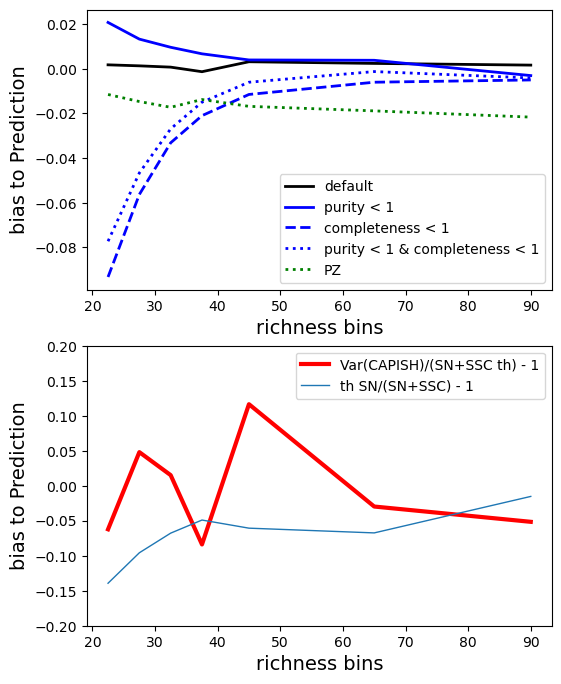

In [72]:
plt.figure(figsize=(6,8))
plt.subplot(211)
res_default_capish_10 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,0], axis=0)
res_default_capish_07 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_noWL_noise.pkl'))[:,0], axis=0)
res_default_capish_07_WL_noise = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise.pkl'))[:,0], axis=0)
res_photoz = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/with_photoz.pkl'))[:,0], axis=0)
rho_m01 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/rho_m0.1.pkl'))[:,0], axis=0)
rho_p01 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.1.pkl'))[:,0], axis=0)
rho_p02 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.2.pkl'))[:,0], axis=0)
not_pure = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/not_pure.pkl'))[:,0], axis=0)
not_complete = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/incomplete.pkl'))[:,0], axis=0)
not_pure_not_complete = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/not_pure_and_incomplete.pkl'))[:,0], axis=0)
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10)/Nfid - 1, '-k',  lw=2, label=r'default')
plt.plot(ClusterAbundanceObject.richness_centers, (not_pure )/Nfid - 1, '-b', lw=2, label = 'purity < 1')
plt.plot(ClusterAbundanceObject.richness_centers, (not_complete)/Nfid - 1, '--b', lw=2,label = 'completeness < 1')
plt.plot(ClusterAbundanceObject.richness_centers, (not_pure_not_complete)/Nfid - 1, ':b', lw=2, 
                                                     label = 'purity < 1 & completeness < 1')
plt.plot(ClusterAbundanceObject.richness_centers, (res_photoz)/Nfid - 1, ':g', lw=2, label = 'PZ')
#plt.ylim(-0.15, 0.15)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel('bias to Prediction', fontsize=14)
plt.legend()


plt.subplot(212)
plt.plot(ClusterAbundanceObject.richness_centers, std_default_capish/np.sqrt(var_th) - 1, '-r', lw=3, label = 'Var(CAPISH)/(SN+SSC th) - 1')
plt.plot(ClusterAbundanceObject.richness_centers, np.sqrt(Nfid)/np.sqrt(var_th) - 1, '-', lw=1, label = 'th SN/(SN+SSC) - 1')
plt.legend()
plt.xlabel('richness')
plt.ylim(-0.20, 0.20)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel('bias to Prediction', fontsize=14)
#plt.plot(ClusterAbundanceObject.richness_centers, std_default_capish/np.sqrt(Nfid) - 1, ':', lw=3, label = 'Default Capish')

In [63]:
gamma = 1
NMfid_gamma, Nth_m = ClusterAbundanceObject.model_mass(params_new, compute_new, adds_new, 
                                                       gamma=gamma,add_WL_weight = True)
Mfid = (NMfid_gamma/Nth_m)**(1/gamma)

Text(0, 0.5, 'bias to Prediction')

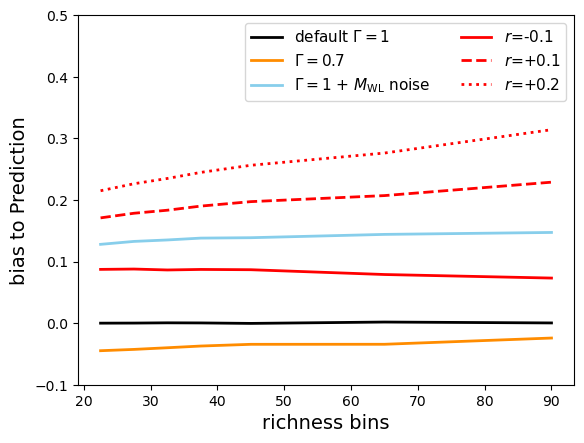

In [71]:
res_default_capish_10 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07_WL_noise = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise.pkl'))[:,1], axis=0)
res_photoz = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/with_photoz.pkl'))[:,1], axis=0)
rho_m01 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_m0.1.pkl'))[:,1], axis=0)
rho_p01 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.1.pkl'))[:,1], axis=0)
rho_p02 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.2.pkl'))[:,1], axis=0)
not_pure = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure.pkl'))[:,1], axis=0)
not_complete = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/incomplete.pkl'))[:,1], axis=0)
not_pure_not_complete = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure_and_incomplete.pkl'))[:,1], axis=0)
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10)/Mfid - 1, '-k',  lw=2, label=r'default $\Gamma=1$')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07)/Mfid - 1, '-', c='darkorange', lw=2,label = r'$\Gamma=0.7$')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07_WL_noise)/Mfid - 1, c='skyblue', lw=2, label =  r'$\Gamma=1$ + $M_{\rm WL}$ noise')

#plt.plot(ClusterAbundanceObject.richness_centers, (not_pure )/Mfid - 1, '-b', lw=2, label = 'purity < 1')
#plt.plot(ClusterAbundanceObject.richness_centers, (not_complete)/Mfid - 1, '--b', lw=2,label = 'completeness < 1')
#plt.plot(ClusterAbundanceObject.richness_centers, (not_pure_not_complete)/Mfid - 1, ':b', lw=2, 
#                                                     label = 'purity < 1 & completeness < 1')

#plt.plot(ClusterAbundanceObject.richness_centers, (res_photoz)/Mfid - 1, ':g', lw=2, label = 'PZ')

plt.plot(ClusterAbundanceObject.richness_centers, (rho_m01)/Mfid - 1, '-r', lw=2,label = r'$r$=-0.1')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_p01)/Mfid - 1, '--r', lw=2, label = r'$r$=+0.1')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_p02)/Mfid - 1, ':r', lw=2, label = r'$r$=+0.2')
plt.legend(fontsize=11, ncols=2)
plt.ylim(-0.1, 0.5)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel('bias to Prediction', fontsize=14)

Text(0.5, 0, 'richness bins')

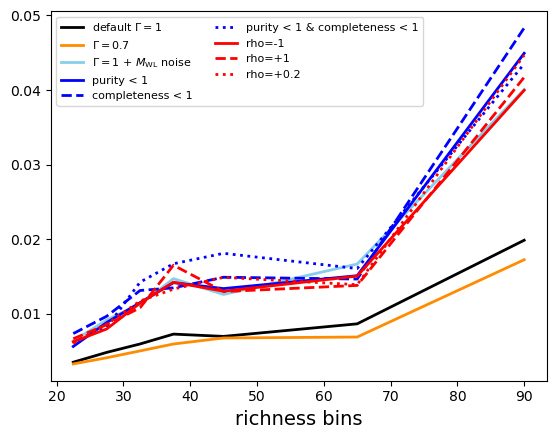

In [73]:
res_default_capish_10 = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07 = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07_WL_noise = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise.pkl'))[:,1], axis=0)
res_photoz = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/with_photoz.pkl'))[:,1], axis=0)
rho_m01 = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_m0.1.pkl'))[:,1], axis=0)
rho_p01 = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.1.pkl'))[:,1], axis=0)
rho_p02 = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.2.pkl'))[:,1], axis=0)
not_pure = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure.pkl'))[:,1], axis=0)
not_complete = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/incomplete.pkl'))[:,1], axis=0)
not_pure_not_complete = np.std(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure_and_incomplete.pkl'))[:,1], axis=0)
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10)/Mfid, '-k',  lw=2, label=r'default $\Gamma=1$')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07)/Mfid, '-', c='darkorange', lw=2,label = r'$\Gamma=0.7$')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07_WL_noise)/Mfid, c='skyblue', lw=2, label =  r'$\Gamma=1$ + $M_{\rm WL}$ noise')

plt.plot(ClusterAbundanceObject.richness_centers, (not_pure)/Mfid, '-b', lw=2, label = 'purity < 1')
plt.plot(ClusterAbundanceObject.richness_centers, (not_complete)/Mfid, '--b', lw=2,label = 'completeness < 1')
plt.plot(ClusterAbundanceObject.richness_centers, (not_pure_not_complete)/Mfid, ':b', lw=2, 
                                                     label = 'purity < 1 & completeness < 1')

#plt.plot(ClusterAbundanceObject.richness_centers, (res_photoz)/Mfid - 1, ':g', lw=2, label = 'PZ')

plt.plot(ClusterAbundanceObject.richness_centers, (rho_m01)/Mfid, '-r', lw=2,label = 'rho=-1')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_p01)/Mfid, '--r', lw=2, label = 'rho=+1')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_p02)/Mfid, ':r', lw=2, label = 'rho=+0.2')
plt.legend(fontsize=8, ncols=2)

plt.xlabel('richness bins', fontsize=14)